In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import tqdm

import torch
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [3]:
from models.vae_novelty import VAE_NOVELTY, Trainer
from visualize import show_auroc

In [4]:
def classify(x, cutoff) :
    if x >= cutoff :
        return 1
    else :
        return 0
    
def equal_to_binary(x) :
    if x == True :
        return 0
    elif x == False :
        return 1
    else : 
        return

# Load Data

In [5]:
def evaluate(random_state, epochs) : 
    
    ################################################################################################################
    # Split Dataset
    batch_size = 32
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(device)
    
    df = pd.read_pickle('data/df_transactions.pkl')
    display(df.head())

    df = df.drop(['Time'], axis=1)
    normal = df[df['Class']==0]
    novel = df[df['Class']==1]

    novel_train, novel_test = train_test_split(novel, train_size=0.1, random_state = random_state)

    columns = normal.drop(['Class'], axis=1).columns

    # x_train : normal only
    # x_valid : normal only
    # x_test : normal + novelty

    x_train, x_valid = train_test_split(normal, train_size=0.6, random_state=random_state)
    x_valid, x_test = train_test_split(x_valid, train_size=0.5, random_state=random_state)

    #x_train = pd.concat([x_train, novel_train])
    x_test = pd.concat([x_test, novel_test])

    standard = StandardScaler()
    x_train['Amount'] = standard.fit_transform(x_train['Amount'].values.reshape(-1, 1))
    x_valid['Amount'] = standard.fit_transform(x_valid['Amount'].values.reshape(-1, 1))
    x_test['Amount'] = standard.fit_transform(x_test['Amount'].values.reshape(-1, 1))

    y_test = x_test['Class']
    x_test = x_test.drop(['Class'], axis=1)
    x_valid = x_valid.drop(['Class'], axis=1)
    x_train = x_train.drop(['Class'], axis=1)

    x_train = torch.from_numpy(x_train.values).float()
    x_valid = torch.from_numpy(x_valid.values).float()
    x_test = torch.from_numpy(x_test.values).float()

    train_loader = DataLoader(x_train, batch_size = batch_size, shuffle=True)
    valid_loader = DataLoader(x_valid, batch_size = batch_size, shuffle=True)

    ################################################################################################################
    # Train Model
    model = VAE_NOVELTY().to(device)

    trainer = Trainer(device, batch_size)
    trainer.fit(model, train_loader, valid_loader, epochs)

    x_test_hat = trainer.transform(x_test)
    recon_error = ((x_test_hat.cpu().detach().numpy() - x_test.cpu().numpy()) ** 2).mean(axis=1)

    cutoff = show_auroc(y_test.values, recon_error)
    # Youden's J-Score
    print("Youden's J-Score (optimal cutoff) : ", cutoff)
    
    ################################################################################################################
    # Check Result
    df_test = pd.DataFrame(x_test.cpu().numpy())
    df_test.columns = columns
    df_test['Amount'] = standard.inverse_transform(df_test['Amount'])
    df_test['ReconError'] = recon_error
    df_test['Class'] = y_test.values
    df_test['Prediction'] = df_test['ReconError'].apply(lambda x : classify(x, cutoff))
    df_test['PredictionDiffersClass'] = (df_test['Class']==df_test['Prediction'])
    df_test['PredictionDiffersClass'] = df_test['PredictionDiffersClass'].apply(lambda x : equal_to_binary(x))
    df_test['Loss'] = df_test['Amount'] * df_test['PredictionDiffersClass']

    plt.figure(figsize=(20, 5))
    sns.distplot(df_test[df_test['Class']==0]['ReconError'], label='0', rug=True, bins=int(180/5))
    sns.distplot(df_test[df_test['Class']==1]['ReconError'], label='1', rug=True, bins=int(180/5))
    plt.legend(['0 : normal', '1 : novelty'])
    plt.title('Distribution of 0 (normal) and 1 (abnormal)')
    plt.show()

    accuracy = accuracy_score(df_test['Class'], df_test['Prediction'])
    total_loss = df_test['Loss'].sum()

    print('Accuracy : ', accuracy)
    print('Total Loss : ', total_loss)
    
    return accuracy, total_loss

# Novely Detection

In [6]:
df = pd.DataFrame(columns=['Accuracy', 'TotalLoss'])

cuda:0


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,FraudType
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,-1
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,-1
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,-1
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,-1
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,-1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Epoch: 100%|██████████| 1/1 [00:28<00:00, 28.08s/it]

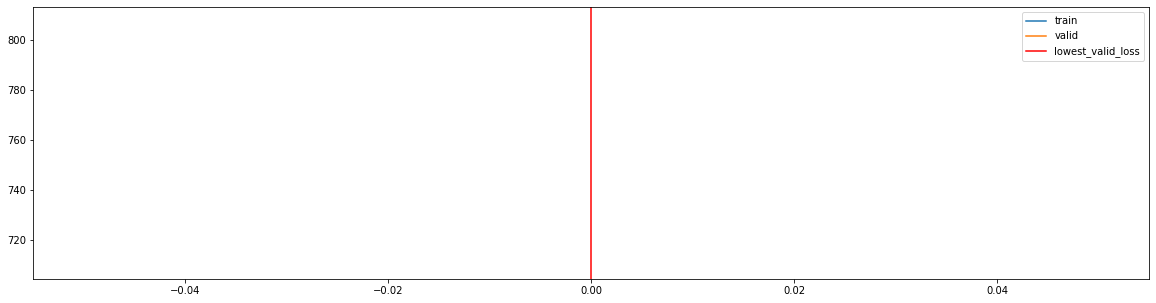

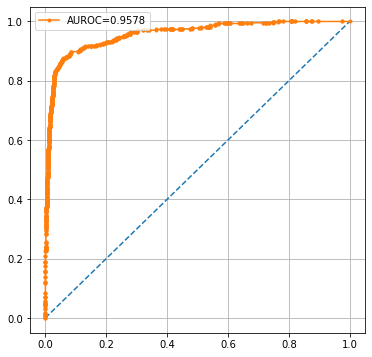

Youden's J-Score (optimal cutoff) :  2.2208695


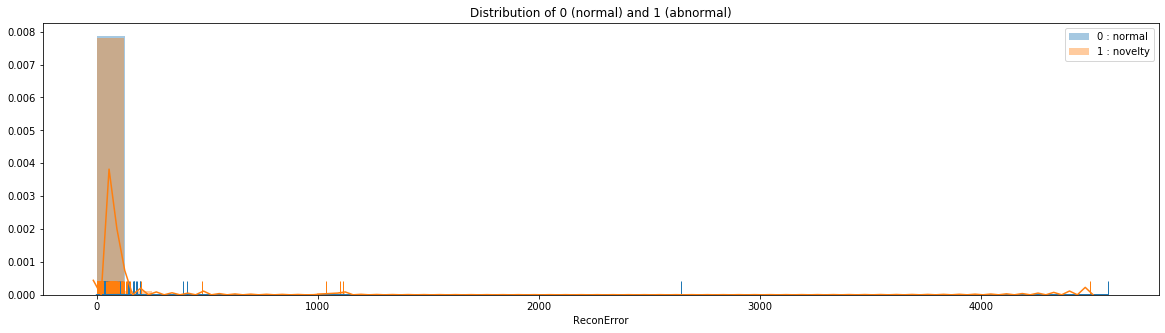

Accuracy :  0.9401982340418106
Total Loss :  1362451.7495197842


In [7]:
random_state = 0
epochs = 1
accuracy, total_loss = evaluate(random_state, epochs)
df.loc[random_state] = [accuracy, total_loss]